### Import

In [1]:
import numpy as np
from scipy.fft import fft, ifft
import scipy
import matplotlib.pyplot as plt
import scipy.signal as signal
from math import ceil
from IPython.display import Audio
from scipy.signal import firwin, lfilter, freqz
from scipy.signal import convolve

### Setup input Sound

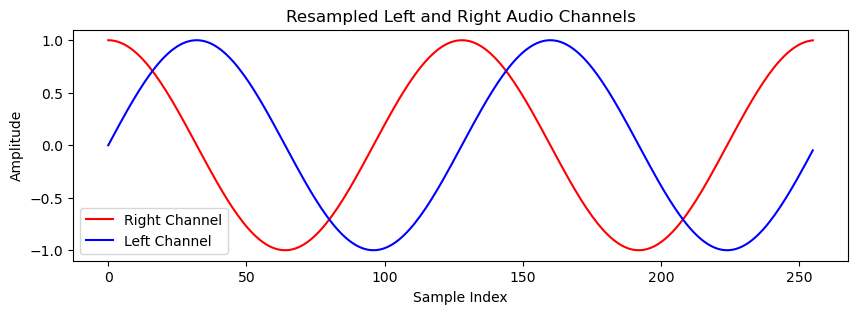

In [147]:
time = 10 #s
start_time = 10 #s
S_R = 48000 #hz
freq=18750/50

REAL_AUDIO= False
SINWAVE = True
SQUAREWAVE = False
DIRAC = False
NOISE = False

if (REAL_AUDIO):
    sampleRate, samples = scipy.io.wavfile.read('audio/track.wav')
    samples = samples / 2**15
    start_sample = int(start_time * sampleRate)
    end_sample = start_sample + int(time * sampleRate)
    trimmed_samples = samples[start_sample:end_sample]
    num_samples = int(len(trimmed_samples) * S_R / sampleRate)
    left_channel = trimmed_samples[:, 0]  # Left channel
    right_channel = trimmed_samples[:, 1]  # Right channel
    #Resample the trimmed audio using Fourier-based interpolation (scipy)
    left_channel = signal.resample(left_channel, num_samples)
    right_channel = signal.resample(right_channel, num_samples)
elif (SINWAVE):
    t = np.linspace(0, time, int(S_R * time), endpoint=False)
    left_channel = np.sin(2 * np.pi * freq * t)
    right_channel = np.sin(2 * np.pi * freq * t+ np.pi/2)
elif(DIRAC):
    left_channel = np.zeros(S_R*time)
    right_channel = np.zeros(S_R*time)
    left_channel[10:15] =1
    right_channel[20:25] = 1
elif(NOISE):
    # Generate noise for both channels
    left_channel = 0.01*np.random.normal(0, 1, S_R * time)
    right_channel = 0.01*np.random.normal(0, 1, S_R * time)
else:
    t = np.linspace(0, time, int(S_R * time), endpoint=False)
    left_channel = signal.square(2 * np.pi * freq * t)
    right_channel = signal.square(2 * np.pi * freq * t+ np.pi/2)
    num_samples = len(t)

plt.figure(figsize=(10, 3))
# Plot the right channel (samples2)
plt.plot(right_channel[:256], label='Right Channel', color='r')
# Plot the left channel (samples1)
plt.plot(left_channel[:256], label='Left Channel', color='b')
# Add title and labels
plt.title('Resampled Left and Right Audio Channels')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
# Add a legend to differentiate the channels
plt.legend()
plt.show()

### SETUP IMPULSE RESPONSE

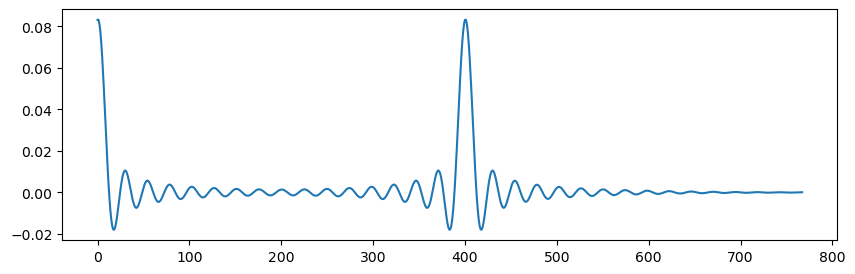

In [125]:
cut_freq = 2000#hz
num_taps=256*3
DIRAC_IR = False

# Design the FIR filter
fir_filter = firwin(num_taps, cut_freq, fs=S_R)

# Generate an impulse signal
impulse_signal = np.zeros(num_taps*2)
impulse_signal[0] = 1
impulse_signal[400]=1


if (DIRAC_IR):
    impulse_response = impulse_signal    
else:
    # Convolve the filter with the impulse signal to get the impulse response
    impulse_response = convolve(impulse_signal, fir_filter, mode='full')

IR = scipy.signal.normalize(impulse_response[np.argmax(impulse_response):np.argmax(impulse_response)+num_taps], [1])[0]
#IR = scipy.signal.normalize(impulse_response, [1])[0]

plt.figure(figsize=(10, 3))
plt.plot(IR)

# Bloc diagram of the algorithm
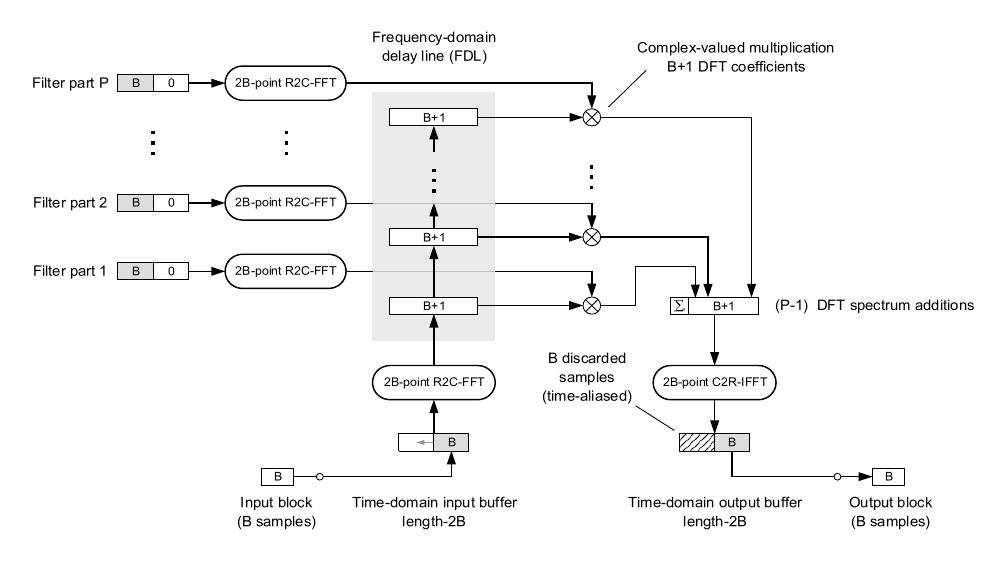

(diagram taken from : Partitioned convolution algorithms for real-time auralization of Franc Wefers)

This time the input block is a complexe signal, the right samples are the imaginary part and the left samples are the real part of that signal:$$x(n) = x_0(n) + i x_1(n)$$
with $$x_0(n)= Re(x(n))$$ and $$ x_1(n)= Im(x(n))$$

$$ IFFT[FFT(x(n))*FFT(h(n))] \equiv  (x_0(n) + i x_1(n)) * h(n)$$

### 

In [126]:
B= 256
K = 2*B # taille de la transformée de fourier (max 512 pour la LPCXPresso55S69 avec powerquad)
P = ceil(len(IR)/B) # nombre de partitions du filtre
N = P*B # longueur du filtre
P_samples_block = ceil(len(left_channel)/B)
print("B =", B, "; K =", K, "; P =", P, "; N =", N,"; P_sample_block =", P_samples_block)

B = 256 ; K = 512 ; P = 3 ; N = 768 ; P_sample_block = 1875


### Processing loop

In [127]:
def UPOLS_fast_conv_stereo(IR, samples1, samples2):
    ## Setup memory regions
    slide_window = np.zeros(2*B).astype('complex128') # buffer d'entrée de taille 2B
    filter_parts_time = np.reshape(np.zeros(2*B*P), (P, 2*B)) # filter partitioned time domain (every block are zeros padded)
    filter_parts_freq = []
    input_blocks = np.reshape(np.zeros(P_samples_block*B), (P_samples_block,B)).astype('complex128')
    output_blocks = np.reshape(np.zeros(P_samples_block*B), (P_samples_block,B)).astype('complex128')
    freq_FDL= np.reshape(np.zeros(2*B*P), (P, 2*B)).astype('complex128')
    acumulator = np.zeros(2*B).astype('complex128')
    
    for i in range(P-1) :
        filter_parts_time[i][:B]= IR[i*B: B*i+B]
    filter_parts_time[P-1][:len(IR[(P-1)*B:])]= IR[(P-1)*B:]
    
    for block in filter_parts_time:
        filter_parts_freq.append(fft(block))

    for i in range(P_samples_block-1):
        input_blocks[i].real = samples1[i*B: (i+1)*B]
        input_blocks[i].imag = samples2[i*B: (i+1)*B]
        
    for i in range(P_samples_block-1):
        # write the new bloc
        slide_window[B:] = input_blocks[i]
        
        # 2B point C2C-FFT
        freq_FDL[i%P] = fft(slide_window)
        
        #reset the acumulator
        acumulator = np.zeros(2*B).astype('complex128')
        
        # PxB multiplication
        for n in range(P):
            acumulator += freq_FDL[(i-n)%P]*filter_parts_freq[n]

        # 2B point C2C-IFFT
        output_blocks[i]=ifft(acumulator)[B:]
        # slide window
        slide_window[:B] = slide_window[B:]      
        
    return output_blocks

# impulse responce of the filter

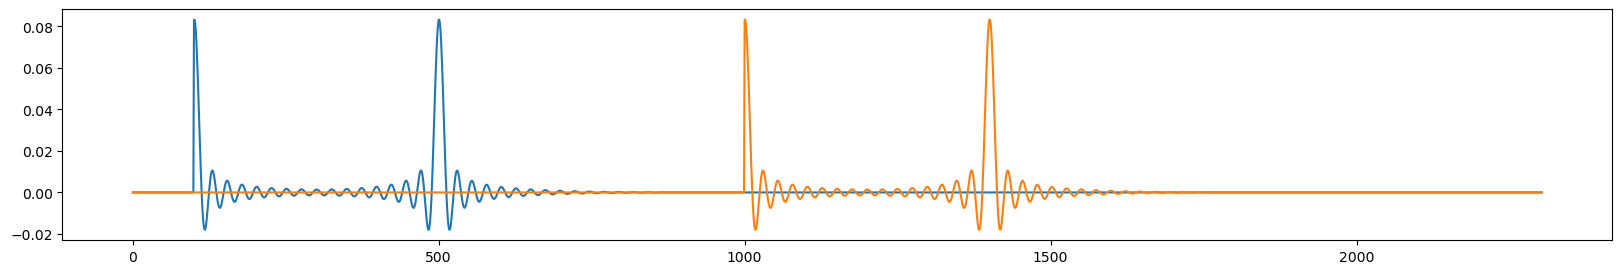

In [128]:
left_channel_test =  np.zeros(S_R*time)
right_channel_test = np.zeros(S_R*time)
left_channel_test[100] = 1
right_channel_test[1000] = 1
output_blocks = UPOLS_fast_conv_stereo(IR, left_channel_test, right_channel_test)
plt.figure(figsize=(20, 3))
plt.plot(np.reshape(output_blocks, (S_R*time))[:3*num_taps].real)
plt.plot(np.reshape(output_blocks, (S_R*time))[:3*num_taps].imag)

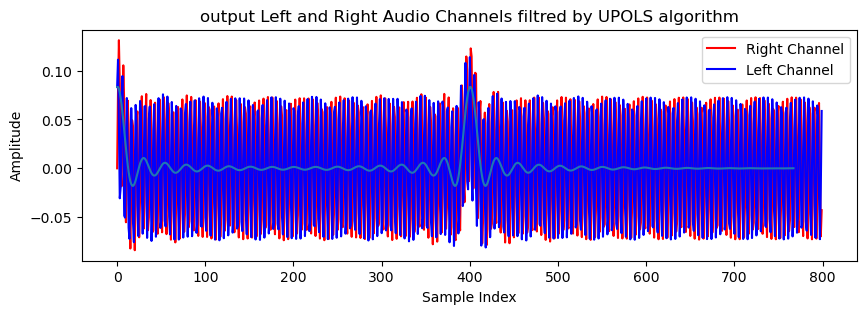

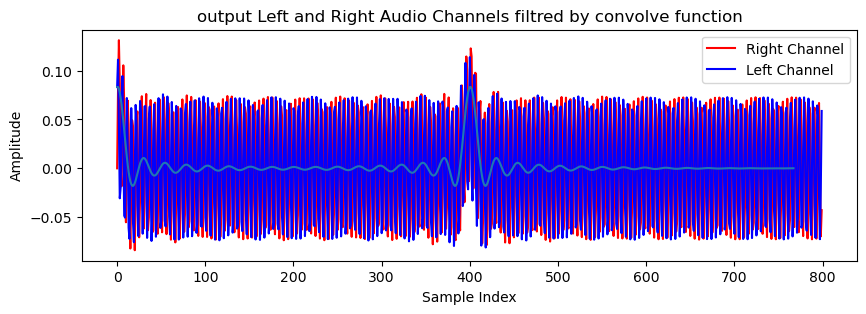

In [135]:
output_blocks = UPOLS_fast_conv_stereo(IR, left_channel, right_channel)
output_right = np.reshape(output_blocks.real, (P_samples_block*B))
output_left = np.reshape(output_blocks.imag, (P_samples_block*B))
plt.figure(figsize=(10, 3))
# Plot the right channel (samples2)
plt.plot(output_right[0:800], label='Right Channel', color='r')
# Plot the left channel (samples1)
plt.plot(output_left[0:800], label='Left Channel', color='b')
plt.plot(IR)
# Add title and labels
plt.title('output Left and Right Audio Channels filtred by UPOLS algorithm')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
# Add a legend to differentiate the channels
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
# Plot the right channel (samples2)
plt.plot(convolve(left_channel[:1000],IR)[:800], label='Right Channel', color='r')
# Plot the left channel (samples1)
plt.plot(convolve(right_channel[:1000],IR)[:800], label='Left Channel', color='b')
plt.plot(IR)
# Add title and labels
plt.title('output Left and Right Audio Channels filtred by convolve function')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
# Add a legend to differentiate the channels
plt.legend()
plt.show()

In [8]:
Audio(output_right, rate= S_R)

In [9]:
Audio(output_left, rate= S_R)

In [10]:
Audio(right_channel, rate = S_R)

In [11]:
Audio(left_channel, rate= S_R)

In [12]:
test_signal= np.zeros(88200)
test_signal[10]=1
Audio(test_signal, rate=44100)

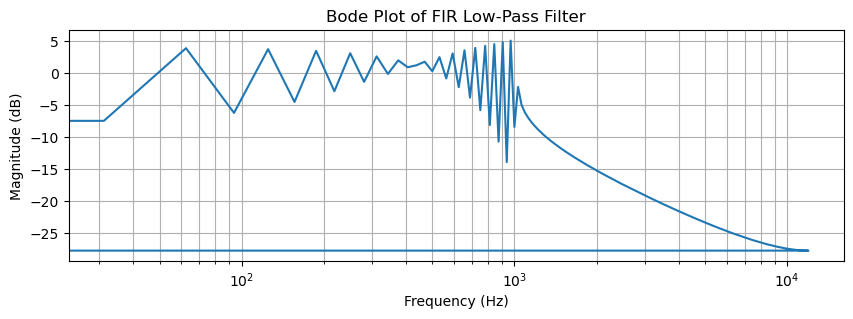

In [106]:
# Compute the frequency response
h = fft(IR)

# Convert to dB scale
h_db = 20 * np.log10(abs(h))
frequency_axis = np.fft.fftfreq(len(IR))

# Plot the Bode plot
plt.figure(figsize=(10, 3))
plt.plot(frequency_axis*S_R/2, h_db)
plt.title('Bode Plot of FIR Low-Pass Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.semilogx()
plt.grid(which='both', axis='both')
plt.show()

## Test
#### plots of the memory regions

#### generation of tests signals

In [148]:
res = 2**15-1
signal_length = 3*256

array_test_signal = np.zeros(2*signal_length)
for i in range(signal_length):
    array_test_signal[2*i] = left_channel[i] *res   # Even indices for left channel
    array_test_signal[2*i+1] = right_channel[i] *res  # Odd indices for right channel

array_IR = IR.real * res

filename = "../source/test_data_array.h"# Open the .h file for writing
with open(filename, "w") as f:
    f.write("/*** DO NOT EDIT THIS FILE ***/\n/* FILE GENERATED BY PYTHON SCRIPT IN jupyter FOLDER*/\n")
    f.write("#ifndef TEST_ARRAY_DATA_H\n")
    f.write("#define TEST_ARRAY_DATA_H\n\n")

    f.write(f"#define FILTER_LENGTH {len(array_IR)}\n\n")
    # test array of data 
    f.write(f"const uint32_t array_size = {len(array_test_signal)};\n")

    f.write("__ALIGN_BEGIN int16_t test_array_data[] = {\n")
    for i, val in enumerate(array_test_signal):
        if i != len(array_test_signal) - 1:
            f.write(f"\t\t{val},")
        else:
            f.write(f"\t\t{val}\n")
        if i%5 == 0:
            f.write("\n")
    f.write("};__ALIGN_END\n\n")

    f.write("const int16_t Impulse_Response[] = {\n")
    for i, val in enumerate(array_IR[:num_taps]):
        if i != len(array_IR[:num_taps]) - 1:
            f.write(f"\t\t{val.astype(np.int16)},")
        else:
            f.write(f"\t\t{val.astype(np.int16)}\n")
        if i%10 == 0:
            f.write("\n")
    f.write("};\n\n")
    
    f.write("#endif // TEST_ARRAY_DATA_H\n")

print(f"Data saved to {filename}")

Data saved to ../source/test_data_array.h


In [15]:
array_IR = IR.real 
filename = "FILTER.TXT"# Open the .h file for writing
with open(filename, "w") as f:
    f.write(f"CCTX\t{num_taps}\t1\t0\n")
    for i, val in enumerate(array_IR[:num_taps]):
        f.write(f"\t{val.astype(np.float32):.{8}f}\n")

print(f"Data saved to {filename}")

Data saved to FILTER.TXT


#### Plot BUFFERS

98491.67219021032


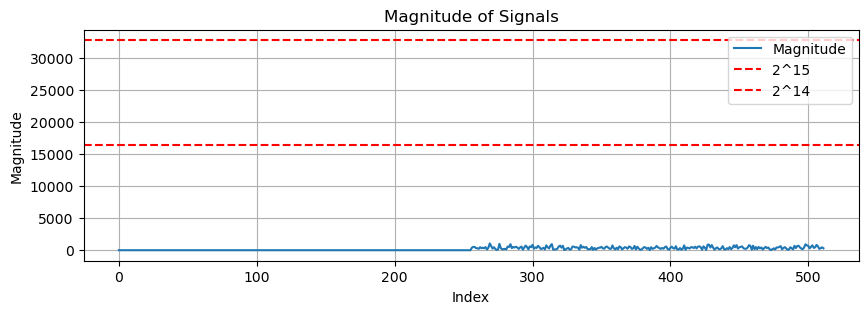

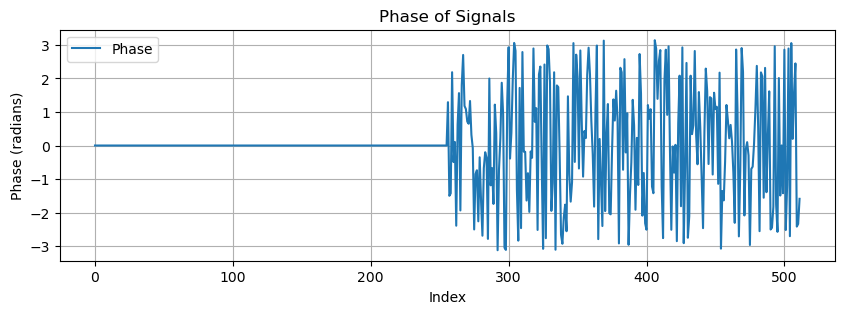

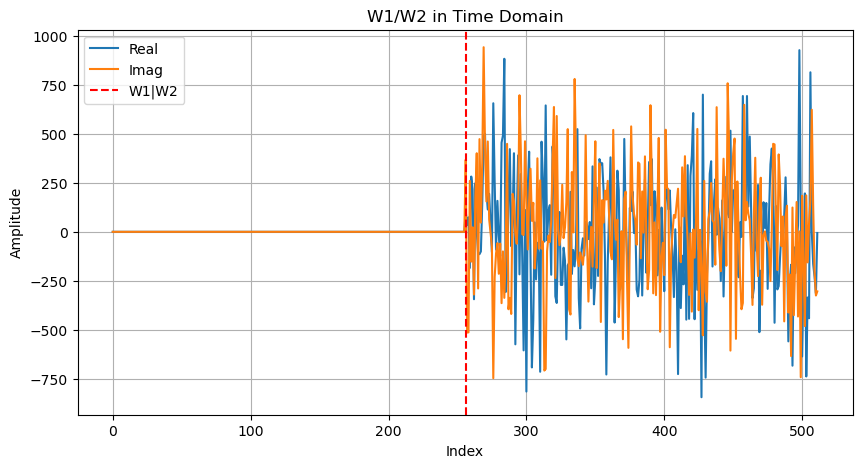

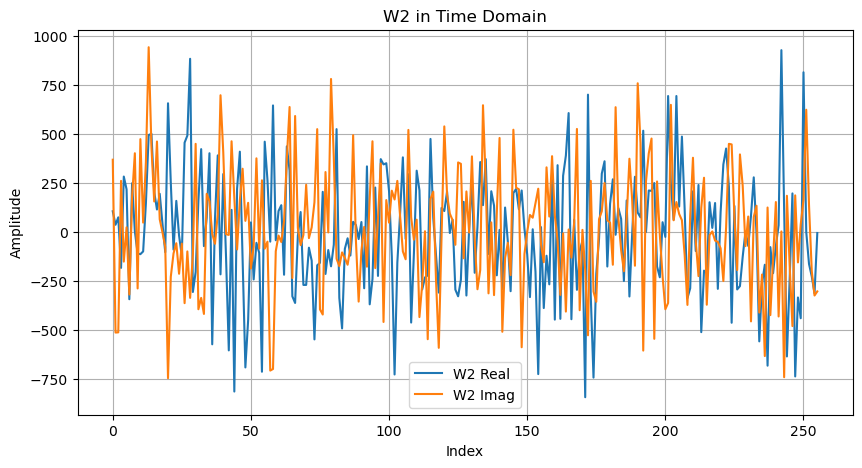

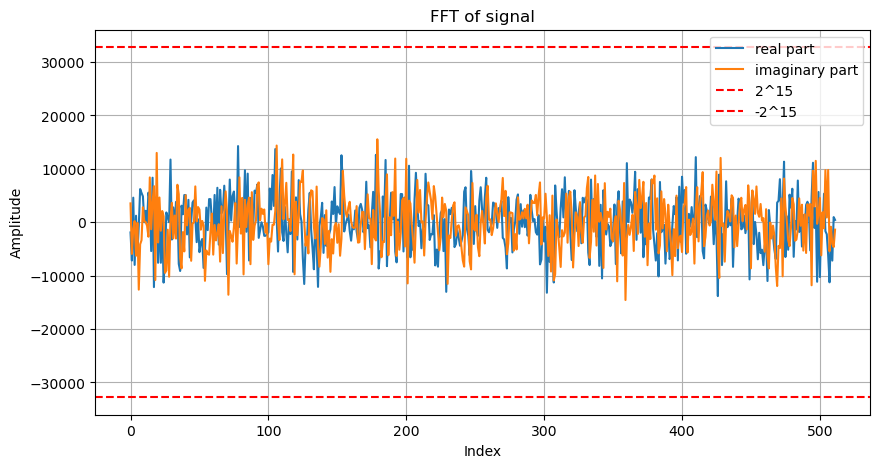

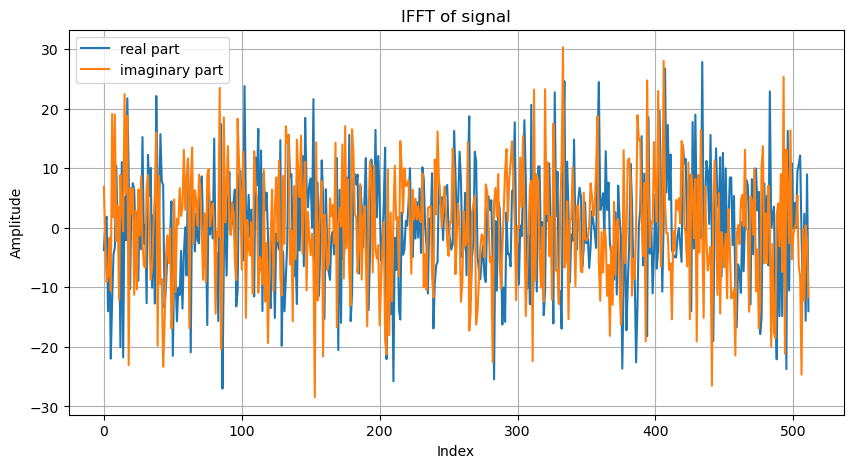

In [109]:
file_path = '../dump/Acumulator'
file_path = '../dump/SlidingWindow'
#file_path = '../dump/FDL'
#file_path = '../dump/Filter'
BLOCK_NUMBER = 1
data = np.fromfile(file_path, dtype=np.int16)[(BLOCK_NUMBER-1)*1024:BLOCK_NUMBER*1024]
data = np.reshape(data, (2, 2*B))
W2 = data[1]
W1 = data[0]
BUFFER_LENGHT = B
W1_real = np.zeros(BUFFER_LENGHT)
W1_imag = np.zeros(BUFFER_LENGHT)
W2_real = np.zeros(BUFFER_LENGHT)
W2_imag = np.zeros(BUFFER_LENGHT)

for i in range(BUFFER_LENGHT):
    W1_real[i]=W1[2*i]
    W1_imag[i]=W1[2*i+1]
    W2_real[i]=W2[2*i]
    W2_imag[i]=W2[2*i+1]

ac_real = np.append(W1_real, W2_real)
ac_imag = np.append(W1_imag, W2_imag)
acumulator = ac_real + 1j*ac_imag
print(np.sum(abs(acumulator)))
# Plotting the magnitude
plt.figure(figsize=(10, 3))
plt.plot(abs(acumulator), label='Magnitude')
plt.axhline(2**15, color='r', linestyle='--', label='2^15')
plt.axhline(2**14, color='r', linestyle='--', label='2^14')
plt.title('Magnitude of Signals')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the phase
plt.figure(figsize=(10, 3))
plt.plot(np.angle(acumulator), label='Phase')
plt.title('Phase of Signals')
plt.xlabel('Index')
plt.ylabel('Phase (radians)')
plt.legend()
plt.grid(True)
plt.show()

a=50
# Plotting W1 and W2 in the time domain
plt.figure(figsize=(10, 5))
plt.title('W1/W2 in Time Domain')
plt.plot(ac_real, label='Real')
plt.plot(ac_imag, label='Imag')
plt.axvline(256, color='r', linestyle='--', label='W1|W2')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(W2_real, label='W2 Real')
plt.plot(W2_imag, label='W2 Imag')
plt.title('W2 in Time Domain')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


FFT_sig = fft(ac_real+1j*ac_imag)
plt.figure(figsize=(10, 5))
plt.plot(FFT_sig.real, label='real part')
plt.plot(FFT_sig.imag, label='imaginary part')
plt.axhline(2**15, color='r', linestyle='--', label='2^15')
plt.axhline(-2**15, color='r', linestyle='--', label='-2^15')
plt.title('FFT of signal')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

IFFT_sig = ifft(ac_real+1j*ac_imag)
plt.figure(figsize=(10, 5))
plt.plot(IFFT_sig.real, label='real part')
plt.plot(IFFT_sig.imag, label='imaginary part')
#plt.axhline(2**15, color='r', linestyle='--', label='2^15')
#plt.axhline(-2**15, color='r', linestyle='--', label='-2^15')
plt.title('IFFT of signal')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
#FDL : 20530
#filter : 20636

904044.8903516328


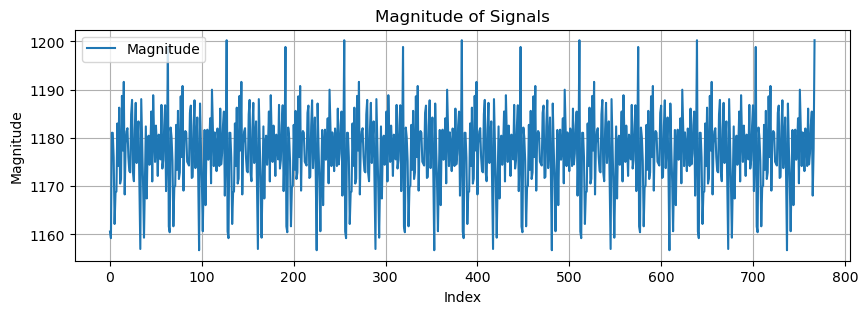

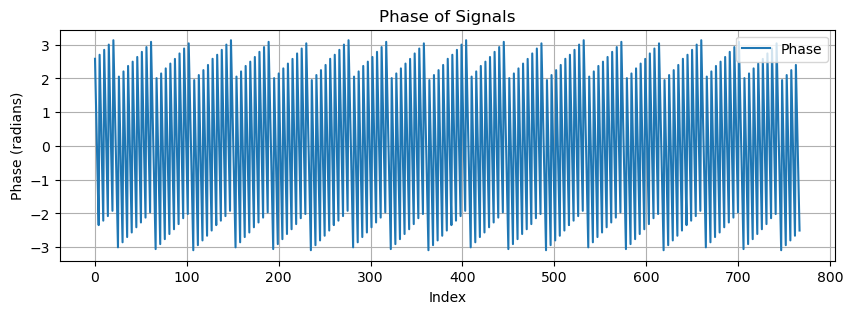

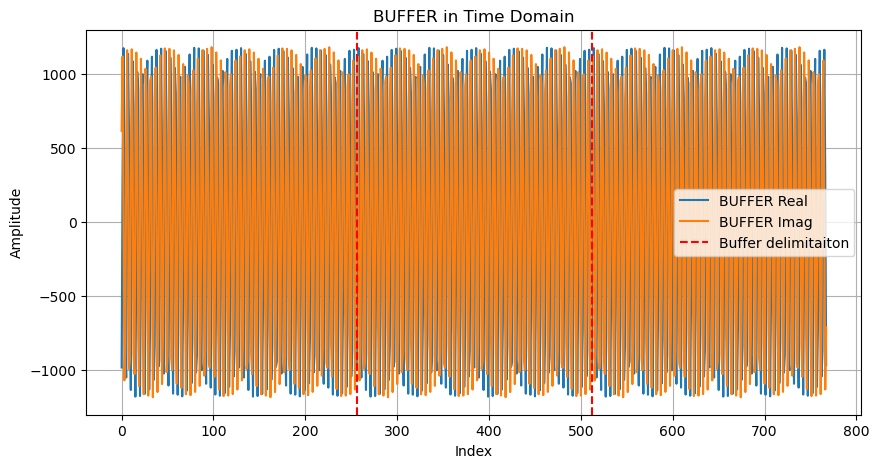

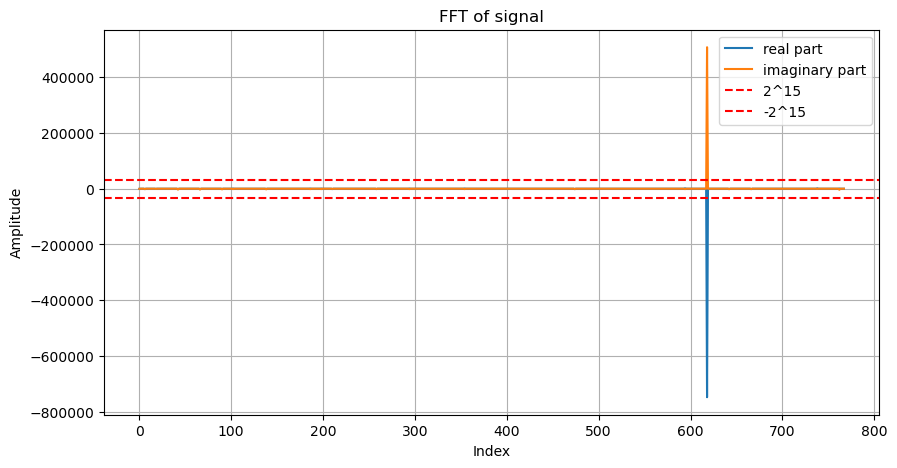

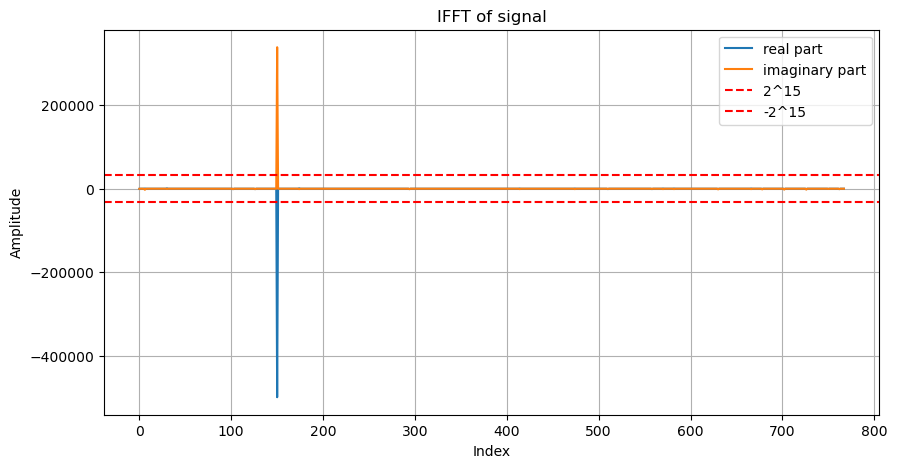

In [149]:
file_path = '../dump/RX_BUFFER'
file_path = '../dump/TX_BUFFER'
BLOCK_NUMBER = 1

data = np.fromfile(file_path, dtype=np.int16)[(BLOCK_NUMBER-1)*1536:BLOCK_NUMBER*1536]
data = np.reshape(data, (3, K))
W3 = data[2]
W2 = data[1]
W1 = data[0]
BUFFER_LENGHT = B
W1_real = np.zeros(BUFFER_LENGHT)
W1_imag = np.zeros(BUFFER_LENGHT)
W2_real = np.zeros(BUFFER_LENGHT)
W2_imag = np.zeros(BUFFER_LENGHT)
W3_real = np.zeros(BUFFER_LENGHT)
W3_imag = np.zeros(BUFFER_LENGHT)

for i in range(BUFFER_LENGHT):
    W1_real[i]=W1[2*i]
    W1_imag[i]=W1[2*i+1]
    W2_real[i]=W2[2*i]
    W2_imag[i]=W2[2*i+1]
    W3_real[i]=W3[2*i]
    W3_imag[i]=W3[2*i+1]
    
ac_real = np.append(W1_real, W2_real)
ac_real = np.append(ac_real, W3_real)
ac_imag = np.append(W1_imag, W2_imag)
ac_imag = np.append(ac_imag, W3_imag)
acumulator = ac_real + 1j*ac_imag
print(np.sum(abs(acumulator)))
# Plotting the magnitude
plt.figure(figsize=(10, 3))
plt.plot(abs(acumulator), label='Magnitude')
plt.title('Magnitude of Signals')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the phase
plt.figure(figsize=(10, 3))
plt.plot(np.angle(acumulator), label='Phase')
plt.title('Phase of Signals')
plt.xlabel('Index')
plt.ylabel('Phase (radians)')
plt.legend()
plt.grid(True)
plt.show()

a=50
# Plotting W1 and W2 in the time domain
plt.figure(figsize=(10, 5))
plt.title('BUFFER in Time Domain')
plt.plot(ac_real, label='BUFFER Real')
plt.plot(ac_imag, label='BUFFER Imag')
plt.axvline(256, color='r', linestyle='--', label='Buffer delimitaiton')
plt.axvline(512, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()



FFT_sig = fft(ac_real+1j*ac_imag)
plt.figure(figsize=(10, 5))
plt.plot(FFT_sig.real, label='real part')
plt.plot(FFT_sig.imag, label='imaginary part')
plt.axhline(2**15, color='r', linestyle='--', label='2^15')
plt.axhline(-2**15, color='r', linestyle='--', label='-2^15')
plt.title('FFT of signal')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

IFFT_sig = ifft(ac_real+1j*ac_imag)*2**9
plt.figure(figsize=(10, 5))
plt.plot(IFFT_sig.real, label='real part')
plt.plot(IFFT_sig.imag, label='imaginary part')
plt.axhline(2**15, color='r', linestyle='--', label='2^15')
plt.axhline(-2**15, color='r', linestyle='--', label='-2^15')
plt.title('IFFT of signal')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
#FDL : 20530
#filter : 20636